# Voting (분류) 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [9]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

from hossam.core import *
from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 보팅 분류기
from sklearn.ensemble import VotingClassifier

# 보팅에서 사용할 알고리즘 -> SVC, SGDClassifier는 확률을 제공하지 않으므로 소프트 보팅에는 적용 불가
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### #02. 데이터 가져오기

In [10]:
origin = my_read_excel(path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB
None

상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThi

## #02. 데이터 전처리

### [1] 이전 예제에서 수립한 전처리 전략 재현

0값을 포함해서는 안되는 변수에 대해 평균으로 대체

### [2] 훈련/검증 데이터 분할 및 데이터 표준화

In [11]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


### [2] 훈련/검증 데이터 분할 및 데이터 표준화

In [12]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #03. 하이퍼파라미터 튜닝

### [1] Voting에 참여시킬 개별 알고리즘 객체 생성

In [13]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
nb = GaussianNB()
dt = DecisionTreeClassifier()
# svm = SVC()
# sgd = SGDClassifier()

### [2] 보팅 분류기 생성

In [14]:
estimators = [('LR', lr), ('KNN', knn), ('NB', nb), ('DT', dt)]
estimators

[('LR', LogisticRegression()),
 ('KNN', KNeighborsClassifier()),
 ('NB', GaussianNB()),
 ('DT', DecisionTreeClassifier())]

### [3] 모듈을 통한 기본 하이퍼파라미터 가져오기

In [15]:
lr_params = get_hyper_params(classname=LogisticRegression)
lr_params

{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [16]:
knn_params = get_hyper_params(classname=KNeighborsClassifier)
knn_params

{'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'weights': ['uniform', 'distance'],
 'metric': ['euclidean', 'manhattan', 'minkowski']}

In [17]:
nb_params = get_hyper_params(classname=GaussianNB)
nb_params

{'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}

In [18]:
dt_params = get_hyper_params(classname=DecisionTreeClassifier)
dt_params

{'criterion': ['gini', 'entropy'],
 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'max_features': ['auto', 'sqrt', 'log2']}

### [4] Voting용 하이퍼 파라미터로 생성

In [19]:
default_params = [('LR', lr_params),
 ('KNN', knn_params),
 ('NB', nb_params),
 ('DT', dt_params)
]

default_params

[('LR',
  {'penalty': ['l1', 'l2', 'elasticnet'],
   'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
 ('KNN',
  {'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
   'weights': ['uniform', 'distance'],
   'metric': ['euclidean', 'manhattan', 'minkowski']}),
 ('NB', {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}),
 ('DT',
  {'criterion': ['gini', 'entropy'],
   'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
   'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
   'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
   'max_features': ['auto', 'sqrt', 'log2']})]

In [20]:
params = {
    "voting": ['hard', 'soft']
}

In [21]:
for n, p in default_params:
    #print(n)
    #print(p)
    
    for k in p:
        #print(f'{n}__{k}')
        params[f'{n}__{k}'] = p[k]

params

{'voting': ['hard', 'soft'],
 'LR__penalty': ['l1', 'l2', 'elasticnet'],
 'LR__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'KNN__n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'KNN__weights': ['uniform', 'distance'],
 'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
 'NB__var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
 'DT__criterion': ['gini', 'entropy'],
 'DT__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'DT__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'DT__max_features': ['auto', 'sqrt', 'log2']}

### [5] 하이퍼파라미터 튜닝

In [22]:
rcv = RandomizedSearchCV(
    estimator=VotingClassifier(estimators), param_distributions=params, 
    n_iter=10, 
    n_jobs=-1, 
    cv=5, 
    verbose=1)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.sort_values(by='mean_test_score', ascending=False)

result_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,voting,NB__var_smoothing,LR__penalty,LR__C,KNN__weights,KNN__n_neighbors,KNN__metric,DT__min_samples_split,DT__min_samples_leaf,DT__max_features,DT__max_depth,DT__criterion,mean_test_score
0,soft,1.000000e-05,l1,0.10,uniform,4,manhattan,7,5,log2,2,gini,NaN
1,soft,1.000000e-07,l1,0.01,uniform,5,euclidean,8,6,auto,3,gini,NaN
2,soft,1.000000e-08,l1,1.00,distance,8,minkowski,2,4,sqrt,7,entropy,NaN
3,soft,1.000000e-07,l2,0.10,distance,9,minkowski,8,1,sqrt,9,gini,0.752459
4,hard,1.000000e-09,l1,10.00,uniform,6,euclidean,3,5,auto,2,gini,NaN
5,soft,1.000000e-07,elasticnet,100.00,uniform,2,euclidean,9,9,sqrt,6,entropy,NaN
6,soft,1.000000e-07,elasticnet,1.00,uniform,5,manhattan,2,2,sqrt,4,entropy,NaN
7,hard,1.000000e-09,l1,10.00,uniform,5,minkowski,5,1,auto,5,entropy,NaN
8,soft,1.000000e-09,l1,1.00,uniform,9,minkowski,3,2,sqrt,3,entropy,NaN
9,soft,1.000000e-06,elasticnet,1.00,uniform,3,euclidean,4,5,log2,5,gini,NaN


In [24]:
rcv.best_estimator_

VotingClassifier(estimators=[('LR', LogisticRegression(C=0.1)),
                             ('KNN',
                              KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance')),
                             ('NB', GaussianNB(var_smoothing=1e-07)),
                             ('DT',
                              DecisionTreeClassifier(max_depth=9,
                                                     max_features='sqrt',
                                                     min_samples_split=8))],
                 voting='soft')

### [6] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.925081 |     0.811688 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.922705 |     0.736842 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.864253 |     0.595745 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0407125 |    0.0934579 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.959288 |     0.906542 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.892523 |     0.658824 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.987922 |     0.865381 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

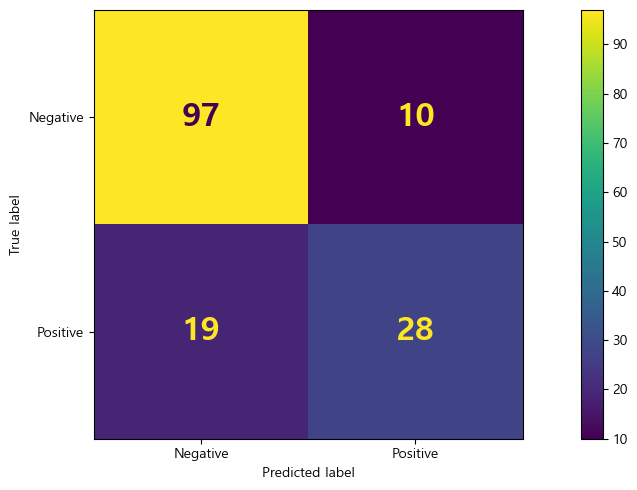


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


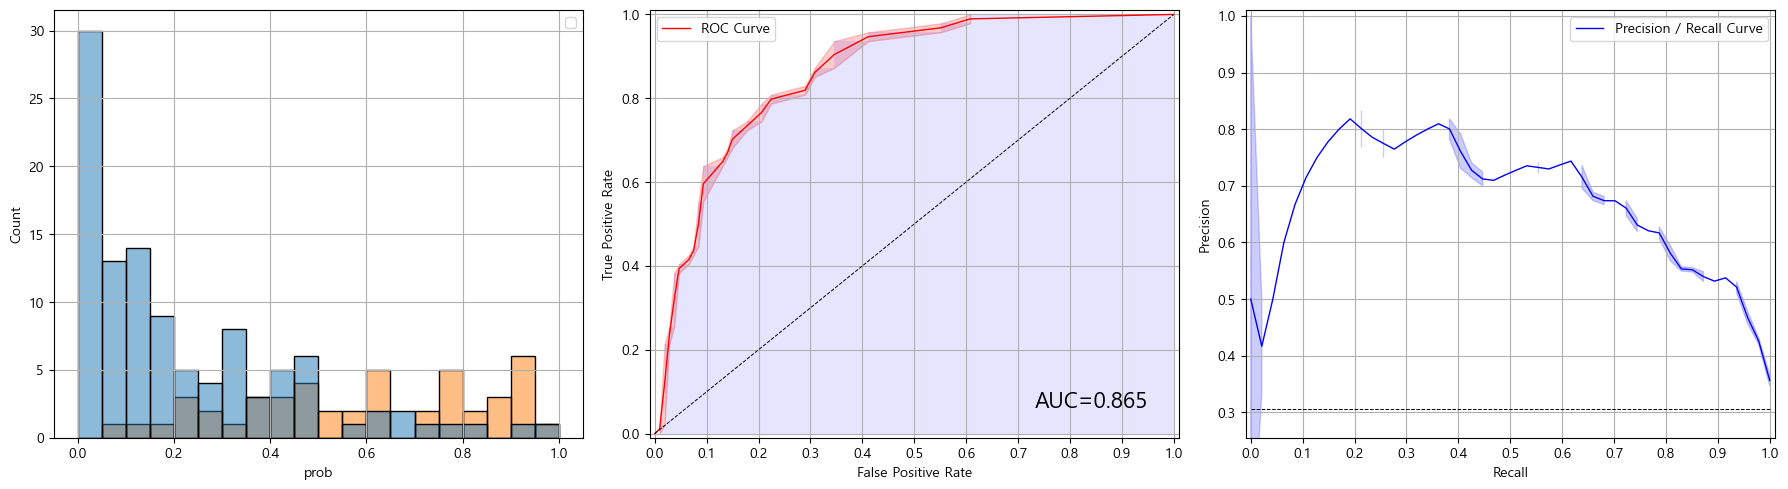


[학습곡선]


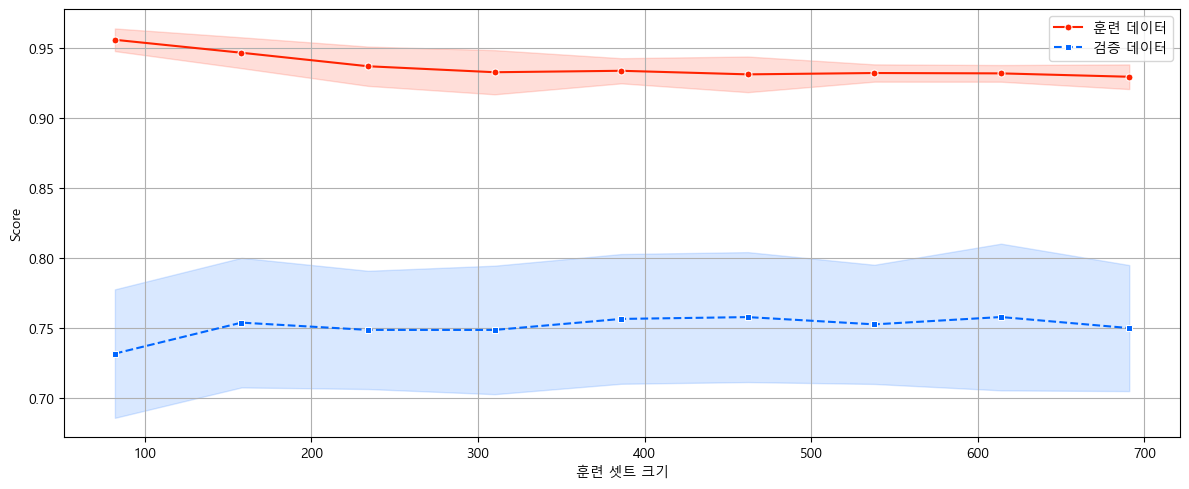

In [23]:
my_classification_result(rcv.best_estimator_, x_train, y_train, x_test, y_test)